In [1]:
import numpy as np
import scipy.optimize as opt
from icecream import ic
import logging
import io
import time
import matplotlib.pyplot as plt
import create_grids, create_polynomials, compute_MC_Residual_Histogram, compute_MC_Residual_Poly, compute_moments

The calibration portion of the replication exercise heavily follows Winberry 2018

First we set the model parameters:

In [2]:
# preferences
beta = .96 # discount rate
sigma = 1 # CRRA
a_bar = 0 # borrowing constraint

#tech
alpha = .36 # capital share
delta = .1  # depreciation

#idiosyncratic shocks
epsilon_grid = np.array([0,1]).reshape((1,2)) #idiosyncratic shocks
N = .93 # Aggregate employment
u_duration = 1
frac_u = u_duration/(1+u_duration)
frac_N = (1-N)/N
epsilon_transition_mat = np.array([frac_u,1-frac_u,frac_N*(1-frac_u),1-(frac_N*(1-frac_u)) ]).reshape((2,2))
epsilon_invariant = np.array([1-N,N]).reshape((2,1))

#unemployment benefits
mu = .15
tau = mu*frac_N

#Aggregate Shocks
rho_TFP = .859
sigma_TFP = .014


Next we set the parameters that control the approximations (chebyshev and distribution):


In [3]:
#Approximation Parameters
n_epsilon = 2 # number of shocks
n_assets = 25  # number of gridpoints for use in asset grid/polynomial interpolation
n_states = n_epsilon*n_assets

#Bounds on Grid space
K_rep_SS = ((alpha*(N**(1-alpha)))/((1/beta)-(1-delta)))**(1/(1-alpha)) #from firm capital FOC
assets_min = a_bar
assets_max = 3*K_rep_SS #ad-hoc

#Finger grid for analyzing policy funcs/histograms
n_assets_fine = 100
n_states_fine = n_epsilon*n_assets_fine

#Degree Approx of distribution for integrating over via quadrature rule
n_measure = 3
n_assets_quad = 8 # number of interpolant points to use for quadrature
n_states_quad = n_epsilon*n_assets_quad
n_measure_coeff = n_epsilon*n_measure

# Optimization params
max_iter = np.int(2e4)
tol = 1e-5
damp = .95

## Solving the Steady State

We begin solving for the steady state of the file. First we construct the grids we need (there are many) using the `create_grids` function.

In [4]:
tic = time.perf_counter()
[   
    asset_cheb_zeros, 
    assets_grid,
    epsilon_mat_grid,
    assets_mat_grid,
    epsilon_grid_prime, 
    assets_grid_fine,
    assets_grid_fine_zeros,
    epsilon_mat_grid_fine,
    assets_mat_grid_fine,
    epsilon_grid_prime_fine,
    assets_grid_quad_zeros,
    quad_weights,
    assets_grid_quad,
    epsilon_grid_mat_quad,
    assets_grid_mat_quad
    ] = create_grids.create_grids(
                                    n_assets,
                                n_assets_fine,
                                n_epsilon,
                                assets_min,
                                assets_max,
                                n_states,
                                n_states_fine,
                                n_assets_quad,
                                epsilon_grid
                                            )
toc = time.perf_counter()
print("{:f} μs".format((toc-tic)*1000)) #5x speedup even without using compiler


2157.885946 μs


Next we construct the chebyshev polynomials on the grid of interest

In [5]:
tic = time.perf_counter()
[ assets_poly,
        assets_poly_sq,
        assets_poly_fine,
        assets_poly_quad,
        assets_poly_BC]=create_polynomials.compute_poly(n_assets,asset_cheb_zeros,assets_grid_fine_zeros, assets_grid_quad_zeros )
toc = time.perf_counter()
print("{:f} μs".format((toc-tic)*1000))

1381.434476 μs


Finally, we begin the process of computing the steady state objects of interest. 

We compute an initial guess of market clearing capital stock using a histogram approx of distribution following (Young, 2010) as done by Winberry to initialize the parametric approx. estimation of the distribution.

In [6]:
print('Computing initial guess from the histogram')
np.seterr(divide='ignore')


Computing initial guess from the histogram


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [7]:
tic = time.perf_counter()
#want to reuse function later on, so create wrapper that only returns 1 of two returns for fsolve to use
f= lambda capital: np.take(compute_MC_Residual_Histogram.compute_MC_Residual_Histogram(capital,alpha,
    N,
    delta,
    beta,
    sigma,
    epsilon_mat_grid,
    assets_mat_grid,
    assets_poly,
    mu,
    tau,
    n_epsilon,
    n_assets,
    n_states,
    n_assets_fine,
    n_states_fine,
    assets_poly_sq,
    assets_poly_fine,
    assets_mat_grid_fine,
    epsilon_mat_grid_fine,
    epsilon_grid_prime,
    epsilon_transition_mat,
    tol,
    max_iter,
    damp,
    a_bar,
    assets_min,
    assets_max, assets_grid_fine ),0)
K_guess,dict_details,ier,msg = opt.fsolve(f, 1.01*K_rep_SS,full_output=True)
toc = time.perf_counter()
print(msg)
print('Initial guess successfully computed with guess K={:}'.format(K_guess))
print('time: {:f} s'.format((toc-tic)))
print('Note how close this is to the SS ignorant est.')

The solution converged.
Initial guess successfully computed with guess K=[4.07545369]
time: 21.173449 s
Note how close this is to the SS ignorant est.


In [8]:
print(K_guess)

[4.07545369]


This was without jitting any of the code. Now we compute the relevant moments of the histogram

In [9]:
tic = time.perf_counter()
return_val=compute_MC_Residual_Histogram.compute_MC_Residual_Histogram(K_guess,alpha,
    N,
    delta,
    beta,
    sigma,
    epsilon_mat_grid,
    assets_mat_grid,
    assets_poly,
    mu,
    tau,
    n_epsilon,
    n_assets,
    n_states,
    n_assets_fine,
    n_states_fine,
    assets_poly_sq,
    assets_poly_fine,
    assets_mat_grid_fine,
    epsilon_mat_grid_fine,
    epsilon_grid_prime,
    epsilon_transition_mat,
    tol,
    max_iter,
    damp,
    a_bar,
    assets_min,
    assets_max, assets_grid_fine)
# gets histogram_matrix 
hist_mat=return_val[1]
toc = time.perf_counter()
print("{:f} μs".format((toc-tic)*1000))


1058.064623 μs


In [10]:
tic = time.perf_counter()
assets_grid_quad = assets_grid_quad.flatten()
moments_hist, grid_moments, constrained = compute_moments.compute_moments_hist(hist_mat, n_epsilon,
    n_measure,
    n_assets_quad,
    assets_grid_fine,
    assets_grid_quad)
toc = time.perf_counter()
print("Time: {:f} μs".format((toc-tic)*1000))

Time: 0.602778 μs


Finally, we compute the market clearing capital stock using the parametric family

In [11]:
# reshapes as needed
quad_weights_vec = quad_weights.reshape((n_assets_quad,1))
tic = time.perf_counter()
f= lambda capital: np.take(compute_MC_Residual_Poly.compute_MC_residual_poly(capital,
    moments_hist,
    grid_moments,
    constrained,
    epsilon_mat_grid,
    epsilon_grid_mat_quad,
    epsilon_grid_prime,
    epsilon_transition_mat,
    assets_mat_grid,
    N,
    n_epsilon,
    n_assets,
    n_assets_quad,
    n_states,
    n_measure,
    assets_min,
    assets_max,
    assets_poly,
    assets_poly_BC,
    assets_poly_sq,
    assets_poly_quad,
    assets_grid_quad,
    epsilon_invariant,
    quad_weights_vec,
    a_bar,
    alpha,
    beta,
    delta,
    mu,
    sigma,
    tau,
    damp,
    tol,
    max_iter),0)
print("Computing Steady State from exponential family:")
if (np.abs(f(K_guess))>1e-4):
    k_ss, infodict2, ier2, msg2 = opt.fsolve(f,K_guess, full_output=True)
toc = time.perf_counter()
print("Done. Time: {:f} s".format(toc-tic))
print("Steady state value of K is:", k_ss)
# prints error if found while evaluating
print(msg2)


Computing Steady State from exponential family:
Done. Time: 36.809905 s
Steady state value of K is: [4.08317874]
The solution converged.


Now we extract the objects of interest from the polynomial estimation.

In [12]:
tic = time.perf_counter()
_,coefs_est, params_est,moments_est, constrained_est, = compute_MC_Residual_Poly.compute_MC_residual_poly(k_ss, moments_hist,
    grid_moments,
    constrained,
    epsilon_mat_grid,
    epsilon_grid_mat_quad,
    epsilon_grid_prime,
    epsilon_transition_mat,
    assets_mat_grid,
    N,
    n_epsilon,
    n_assets,
    n_assets_quad,
    n_states,
    n_measure,
    assets_min,
    assets_max,
    assets_poly,
    assets_poly_BC,
    assets_poly_sq,
    assets_poly_quad,
    assets_grid_quad,
    epsilon_invariant,
    quad_weights_vec,
    a_bar,
    alpha,
    beta,
    delta,
    mu,
    sigma,
    tau,
    damp,
    tol,
    max_iter)
toc = time.perf_counter()
print('Time: {:f}'.format(toc-tic))

Time: 3.756187


We now compute the decision rules in SS along the finer histogram grid for analysis and plotting

In [13]:
# return assets grid, consumption grid, hist_grid
_,hist_mat, assets_prime, consumption = compute_MC_Residual_Histogram.compute_MC_Residual_Histogram(k_ss,alpha,
    N,
    delta,
    beta,
    sigma,
    epsilon_mat_grid,
    assets_mat_grid,
    assets_poly,
    mu,
    tau,
    n_epsilon,
    n_assets,
    n_states,
    n_assets_fine,
    n_states_fine,
    assets_poly_sq,
    assets_poly_fine,
    assets_grid_fine,
    epsilon_mat_grid_fine,
    epsilon_grid_prime,
    epsilon_transition_mat,
    tol,
    max_iter,
    damp,
    a_bar,
    assets_min,
    assets_max, assets_grid_fine)
# compute density among grid
density_fine = np.zeros((n_epsilon,n_assets_fine))
for i_epsilon in np.arange(0,n_epsilon):
    # compute first moment
    grid_moments_fine = np.zeros((n_assets_fine,n_measure))
    grid_moments_fine[:,0] = assets_grid_fine - moments_est[i_epsilon,0]

    # higher order moments (centered)
    for i_moments in np.arange(1, n_measure):
        grid_moments_fine[:,i_moments] = (assets_grid_fine.ravel()  - moments_est[i_epsilon,0])**(i_moments+1) -  moments_est[i_epsilon,i_moments]
        #compute  density away from the borrowing constraint
        density_fine[i_epsilon,:] = params_est[i_epsilon,0]*np.exp(grid_moments_fine@params_est[i_epsilon:i_epsilon+1,1:n_measure+1].T).flatten()


In [14]:
print("Consumption:")
print(consumption)
print("Constrained Frac:")
print(constrained_est)

Consumption:
[[0.16352223 0.28072535 0.35430821 0.42468543 0.47779906 0.52194956
  0.56446086 0.60643087 0.64570389 0.68032831 0.71010889 0.73633907
  0.76073839 0.78454266 0.80814229 0.83121138 0.85309317 0.87320706
  0.8913163  0.90759352 0.92251311 0.93665507 0.95051195 0.96436264
  0.97823684 0.99196053 1.00525311 1.01783902 1.02954031 1.04032698
  1.05031762 1.05973777 1.06885379 1.07790374 1.08704362 1.09632049
  1.10567548 1.11497249 1.12404295 1.13273441 1.14095087 1.14867592
  1.15597426 1.16297324 1.16983026 1.17669503 1.18367601 1.19081838
  1.19809813 1.20543254 1.21270403 1.21979127 1.22660016 1.23308732
  1.23927057 1.24522418 1.25106034 1.25690155 1.26285072 1.26896635
  1.27524882 1.28164118 1.28804446 1.29434417 1.30044132 1.30628025
  1.31186548 1.31726256 1.32258174 1.32794811 1.33346586 1.33918641
  1.34509036 1.3510897  1.35705205 1.3628417  1.36836637 1.37361438
  1.37866761 1.38368162 1.38883426 1.39425695 1.39997246 1.40586682
  1.41171695 1.41727732 1.42240185 

Our answers exactly match Winberry up to at least two decimal places, which is due numerical differences/rounding.  Finally we plot our results

In [15]:
# makes plots higher resolution by default
%config InlineBackend.figure_format = 'retina'

Savings function:

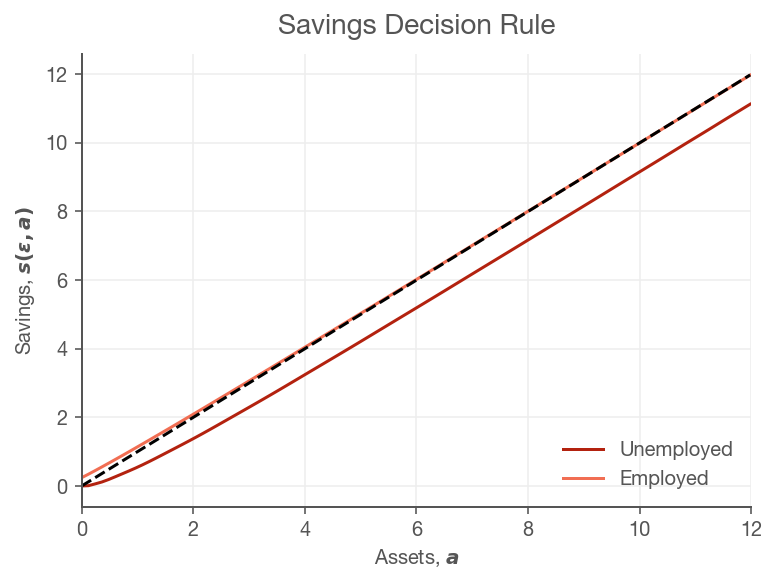

In [16]:
# savings function
plt.figure()
plt.plot(assets_grid_fine.ravel(), assets_prime[0,:],assets_grid_fine.ravel(), assets_prime[1,:],assets_grid_fine.ravel(), assets_grid_fine.ravel(), 'k--' )
plt.ylabel(r'Savings, $s(\varepsilon,a)$')
plt.xlim([a_bar,12])
plt.xlabel(r'Assets, $a$')
plt.title('Savings Decision Rule')
plt.legend(('Unemployed', 'Employed'), loc = 'lower right')
plt.grid()
plt.show()


Consumption function:


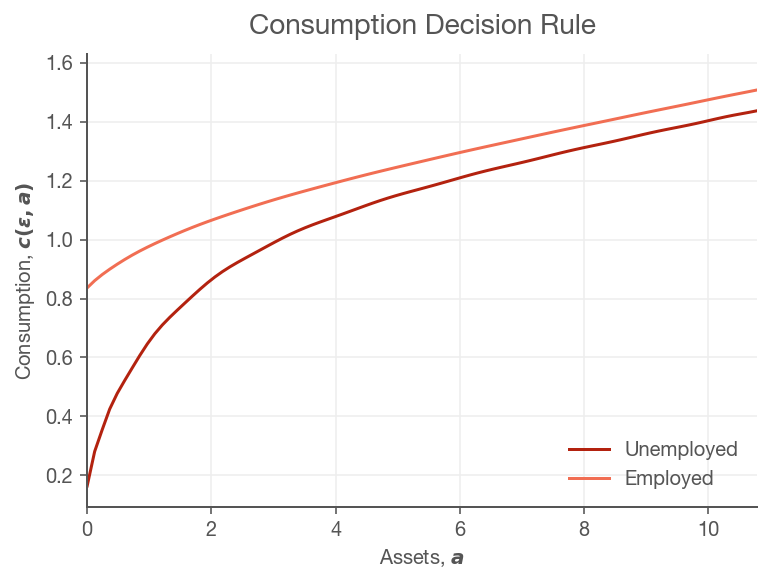

In [17]:
plt.figure()
plt.plot(assets_grid_fine.T, consumption[0,:])
plt.plot(assets_grid_fine.T, consumption[1,:])
plt.xlabel(r'Assets, $a$')
plt.ylabel(r'Consumption, $c(\varepsilon,a)$')
plt.xlim([a_bar,.9*assets_max])
plt.title('Consumption Decision Rule')
plt.legend(('Unemployed', 'Employed'), loc='lower right')
plt.grid()
plt.show()

Distribution of unemployed households:

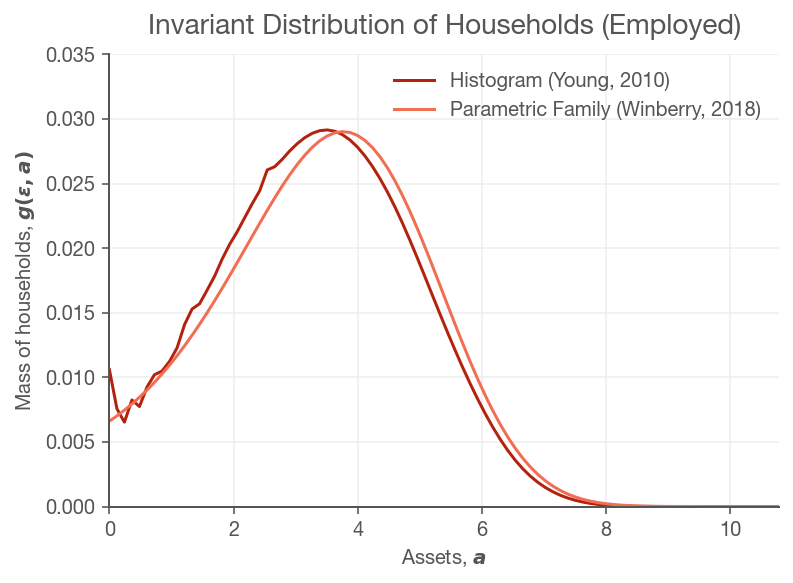

In [28]:
plt.figure()
plt.plot(assets_grid_fine.T, hist_mat[0,:].T/np.sum(hist_mat[0,:],1))
plt.plot(assets_grid_fine.T, density_fine[0,:].T/np.sum(density_fine[0,:]))
plt.xlabel(r'Assets, $a$')
plt.ylabel(r'Mass of households, $g(\varepsilon,a)$')
plt.xlim([a_bar, .9*assets_max])
plt.title('Invariant Distribution of Households (Employed)')
plt.legend(('Histogram (Young, 2010)', 'Parametric Family (Winberry, 2018)'), loc = 'top right')
plt.ylim([0,.035])
plt.grid()
plt.show()

Note the relative lack of mass who are constrained. This is because we are in the base Aiyagari framework and using a continuous distribution, where only ~9.6e-3 and 7e-4 are borrowing constrained in SS in the Histogram. There is a point mass representing this exactly at 0, independent of the grid... however note due to the density being smooth, we don't fully capture this in the assumed form. A slightly different specification around 0 might help with this.

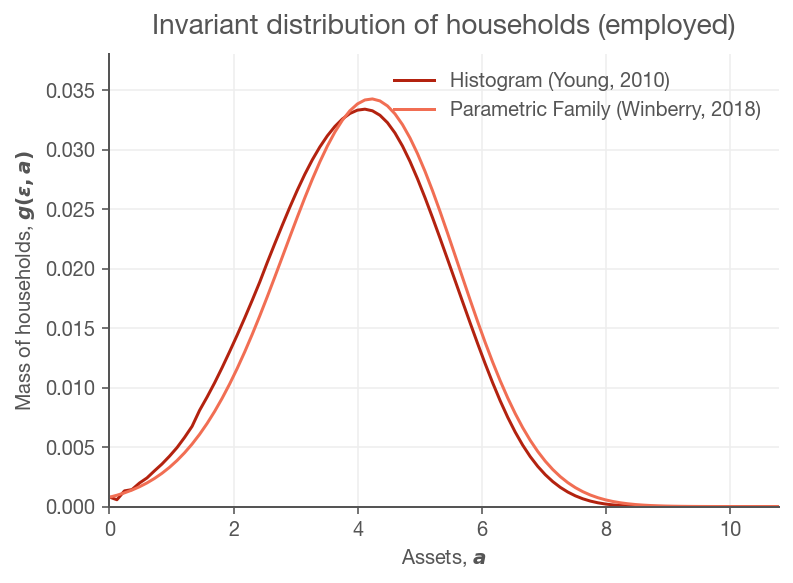

FileNotFoundError: [Errno 2] No such file or directory: '~/Downloads/ivar_dist.jpg'

In [31]:
plt.figure()
plt.plot(assets_grid_fine.T, hist_mat[1:2,:].T/np.sum(hist_mat[1:2,:],1))
plt.plot(assets_grid_fine.T, density_fine[1:2,:].T/np.sum(density_fine[1:2,:],1))
plt.xlabel(r'Assets, $a$')
plt.ylabel(r'Mass of households, $g(\varepsilon,a)$')
plt.xlim([a_bar,.9*assets_max])
plt.title('Invariant distribution of households (employed)')
plt.legend(('Histogram (Young, 2010)', 'Parametric Family (Winberry, 2018)'), loc='top right')
plt.ylim([0,.038])
plt.grid()
plt.show()
plt.savefig('ivar_dist.jpg')


## Dynamics

First we export our data back to matlab to make it compatible with dynare.

In [20]:
import matlab.engine
import scipy.io.matlab as matl
# saves a .mat file consisting of computed variables for use in dynare
# save as a dictionary containing economic parameters
assets_poly_sq = assets_poly_sq.reshape((25,1))
epsilon_grid = epsilon_grid.reshape((2,1))
economic_parameters ={'beta': beta, 'sigma': sigma, 'aBar': a_bar, 'aalpha': alpha, 'delta': delta, 'vecEpsilonGrid': epsilon_grid, 'N': N, 'mu': mu, 'tau':tau, 'rhoTFP': rho_TFP, 'sigmaTFP': sigma_TFP, 'matEpsilonTransition': epsilon_transition_mat}
matl.savemat('economicParameters.mat', economic_parameters)
# save a dict containing approximation parameters -> .mat file 
# dynare reserves 'NSTATES' as an object so cannot name as nStates
approximation_parameters = {'nEpsilon': n_epsilon, 'nAssets': n_assets, 'nState': n_states, 'assetsMin': assets_min, 'assetsMax': assets_max, 'nAssetsFine': n_assets_fine, 'nStateFine': n_states_fine, 'nAssetsQuad': n_assets_quad, 'nStateQuad': n_states_quad, 'nMeasure': n_measure, 'nMeasureCoefficients': n_measure_coeff, 'kRepSS': K_rep_SS, 'maxIterations': max_iter, 'tolerance': tol, 'dampening': damp }
matl.savemat('approximationParameters.mat', approximation_parameters)
# save a dict containing grids -> .mat file
grids = {'vecAssetsGridZeros': asset_cheb_zeros, 'vecAssetsGrid': assets_grid, 'matEpsilonGrid': epsilon_mat_grid, 'matAssetsGrid': assets_mat_grid, 'matEpsilonPrimeGrid': epsilon_grid_prime, 'vecAssetsGridFine': assets_grid_fine, 'vecAssetsGridFineZeros': assets_grid_fine_zeros, 'matEpsilonGridFine': epsilon_mat_grid_fine, 'matAssetsGridFine': assets_mat_grid_fine, 'matEpsilonPrimeGridFine': epsilon_grid_prime_fine, 'vecQuadWeights': quad_weights_vec, 'vecAssetsGridQuadZeros': assets_grid_quad_zeros, 'vecAssetsGridQuad': assets_grid_quad, 'matEpsilonGridQuad': epsilon_grid_mat_quad, 'matAssetsGridQuad': assets_grid_mat_quad}
matl.savemat('grids.mat', grids)
# save a dict containing polynomials -> .mat file 
polynomials = {'vecAssetsPoly': assets_poly, 'vecAssetsPolySquared': assets_poly_sq, 'vecAssetsPolyFine': assets_poly_fine, 'vecAssetsPolyQuad': assets_poly_quad, 'vecAssetsPolyBC': assets_poly_BC}
matl.savemat('polynomials.mat', polynomials)
#provides values to variables
steadystate = {'aggregateCapital': k_ss, 'mHat': constrained, 'matCoefficients':coefs_est, 'matParameters': params_est, 'matMoments': moments_est} 
matl.savemat('steadystate.mat', steadystate)

Now we run dynare on some dynare specific files with our .mat data we created from the steady state. We could also call octave from within python as well if we wanted instead using `oct2py`. The actual dynare code is very similar to Winberry's. If there is time or else in future, I will code up a replacement in Python instead leveraging sympy for greater stability/handle higher order perturbations.

In [21]:
eng = matlab.engine.start_matlab()

In [22]:
script = "dynare dynamics_polynomials"
with open("dynamics.m","w+") as f:
    f.write(script)
out = io.StringIO()
err = io.StringIO()

In [23]:
eng.dynamics(nargout=0, stdout = out, stderr = err)

In [24]:
#!! scroll down to see coefficients !!
print("Output:")
print(out.getvalue())
print(err.getvalue())

Output:

Configuring Dynare ...
[mex] Generalized QZ.
[mex] Sylvester equation solution.
[mex] Kronecker products.
[mex] Sparse kronecker products.
[mex] Local state space iteration (second order).
[mex] Bytecode evaluation.
[mex] k-order perturbation solver.
[mex] k-order solution simulation.
[mex] Quasi Monte-Carlo sequence (Sobol).
[mex] Markov Switching SBVAR.

Using 64-bit preprocessor
Starting Dynare (version 4.5.7).
Starting preprocessing of the model file ...
Found 71 equation(s).
Evaluating expressions...done
Computing static model derivatives:
 - order 1
Computing dynamic model derivatives:
 - order 1
Processing outputs ...
done
Preprocessing completed.


Computing steady state...
> In dynamics_polynomials_steadystate (line 30)
  In evaluate_steady_state_file (line 52)
  In evaluate_steady_state (line 212)
  In resol (line 104)
  In stoch_simul (line 89)
  In dynamics_polynomials (line 3270)
  In dynare (line 235)
  In dynamics (line 1)
> In dynamics_polynomials_steadystate (

In [25]:
#prints out any warnings given
eng.exit()
with open("dynamics_polynomials.log") as f:
    f=f.readlines()
for line in f:
    print(line)

Starting Dynare (version 4.5.7).

Starting preprocessing of the model file ...


Found 71 equation(s).

Evaluating expressions...done

Computing static model derivatives:

 - order 1

Computing dynamic model derivatives:

 - order 1

Processing outputs ...

done

Preprocessing completed.



Running for both a first and second order approximation, we see practically no difference in the Aiyagari model showing that the nonlinearity is not important. It would be interesting to test on a HANK model.